Generate Figure 3 of the original manuscript (PEL-Potential Energy Landscape)
>> 44-order QAOA Turyn

In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00


In [2]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 39.6 MB/s eta 0:00:00


In [3]:
!pip install sympy

In [4]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=ad3021363c41d620aa1a60bfa031d24f2ed73b6c968bb77320929964d0c4d4ff
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


*** FUNCTIONs DEFINITION

In [5]:
#*** Functions Definitions ***
##
from sympy import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import Aer
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
# ///////////////////
N_LAYER= 1 #6
#-------------------------------------
# convert binary {0,1} -> spin {-1, +1}
# -- variables
def b2s(x):
    if (x<1):
        s= 1.0
    if (x>0):
        s= -1.0
    return s
#-------------------------------------
############################################################
# Evaluasi fungsi secara simbolik
# Waktu eksekusi lama, kurang cocok untuk orde tinggi
############################################################
def obj_si(tv, Es):
    # evaluate objective function for a string tv
    #Es=sympify(E12)
    # //// possibly need bit-> spin variable conversion
    NQ=len(tv)
    ss=symbols('s0:%d'%NQ)
    #
    for n in range(0,NQ):
        Es=Es.subs(ss[n],tv[n])
    # --
    obj=Es.evalf()
    return obj
#--

# //// fungsi objective untuk kasus matriks Hadamard
# ///  di sini hanya untuk H-68
def hadamard_obj(vs, Es):
    # value of objective function
    # TO BE MODIFIED WITH HADAMARD MATRIX ??
    ##############################################
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        x: str
           solution bitstring
    Returns:
        obj: float
             Objective
    """
    ##///////////////////////
    obj=obj_turyn_44(vs)
    #gIter=gIter+1
    F_Found=0
    if abs(obj)<0.00001:
        F_Found=1
        GEN_SOL.append(vs)
        #print('Solution Found ...! Iter->', len(vObj),
        #      'E->', obj, 'Sol->', vs)
    return obj, F_Found #, SOL

# /////////////////////////////////////////////////////
# hitung rata-rata energi dari semua solusi
# diam-diam diasumsikan, dengan menurunkan rata-rata
# energi semua solusi, maka solusi yang diinginkan
# atau E=0 dapat dicapai -->> belum tentu benar (?)
# /////////////////////////////////////////////////////
def compute_expectation(counts):
    """
    Computes expectation value based on measurement results
    Args:
        counts: dict
                key as bitstring, val as count
    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    cnt_corr_sol=0
    for bitstring, count in counts.items():
        #obj, SOL = hadamard_obj(bitstring)
        ### print('bitstring->', bitstring, 'Es>>', Es)
        obj, F_Found = hadamard_obj(bitstring, Es)
        if F_Found>0:
            cnt_corr_sol=cnt_corr_sol+count
            #print('Correct Sol->', count)
        avg += obj * count
        sum_count += count
    #print('Total Sample->',sum_count, ', correct sol->', cnt_corr_sol)
    ##
    vShots.append(sum_count)
    vCorrect.append(cnt_corr_sol)
    ##
    return avg/sum_count


# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(p, shots=1*512):
    """
    Runs parametrized circuit
    Args:
        p: int,
           Number of repetitions of unitaries
    """

    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    #gIter=0
    def execute_circ(theta):

        # benchmark->
        #qc=create_qaoa_circ_44(NQ, theta)
        #/// sudah oke untuk order-44
        qc=create_qaoa_circ_from_terms(qx,nqubits,theta)
        #--
        #print(qc.draw())
        # --
        counts = backend.run(qc, seed_simulator=10,
                             nshots=1*512).result().get_counts()
        mean_obj=compute_expectation(counts)
        vObj.append(mean_obj)
        #return compute_expectation(counts)
        return mean_obj
    #
    return execute_circ

In [6]:
## From prb_obj_turyn
#////////////////////////////////////////////////////
# order: 44
#////////////////////////////////////////////////////
def obj_turyn_44(tv):
    # calculate the value of objective function
    # i.e. Hamiltonian's energy of a solution/bitstring
    # order 44--> 5 qubits
    # /////////// harusnya konversi [0,1] -> [-1, +1] ...??????
    ## >> revised
    ##-H44->> NQ=5 (non-hybrid)
    s0=b2s(int(tv[0]))
    s1=b2s(int(tv[1]))
    s2=b2s(int(tv[2]))
    s3=b2s(int(tv[3]))
    s4=b2s(int(tv[4]))
    #####################################
    # ------------------------------------------------------------------------
    obj= (s0*s1*s2 + s0*s3*s4 + s0*s3 - s0*s4 + s1*s2*s3*s4 + s1*s2*s3
          + 2*s1*s2 + s1*s3*s4 + s1*s3 + s1*s4 + s1 + s2*s3*s4 + s2*s3
          + s2*s4 + s2 + s4 + 5)
    # ------------------------------------------------------------------------
    obj=abs(obj) ## since we seek for a minimum
    return obj
#////////////////////////////////////////////////////
#--

In [7]:
##prb_h2qcircuit
###############################
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 26 02:51:18 2022
# module
# convert hamiltonian to quantum circuit
@author: quanta
"""
from qiskit import QuantumCircuit
#, ClassicalRegister, QuantumRegister

#////////////////////////////////////
# -- 1-body --
def U_C_1body(qc, c, gamma, qbs):
    # ---[ 2*C*gamma] --->
    # konstanta c, taruh dimana?
    qc.rz(2*c*gamma, qbs)
#
# -- 2-body --
def U_C_2body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.rz(2*c*gamma, qbs[1])
    qc.cx(qbs[0], qbs[1])
    # no return, assume qml global

# -- 3-body --
def U_C_3body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.cx(qbs[1], qbs[2])
    #
    qc.rz(2*c*gamma, qbs[2])
    #
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[0], qbs[1])

# -- 4-body --
def U_C_4body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[2], qbs[3])
    #
    qc.rz(2*c*gamma, qbs[3])
    #
    qc.cx(qbs[2], qbs[3])
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[0], qbs[1])

#--
###
def term_2_qidx(term):
    # ---------------------------------------------------------
    # convert energy/hamiltonian terms into coefficient and
    # indices of qubit
    # --- qubit ordering may not follow the terms: ??
    # input: term (symbolic)
    # output: [coeff, [qidx0, qidx1, ...]]
    # ---------------------------------------------------------
    coeff=1.0
    #split term into atoms
    atm=term.atoms()
    N=len(atm)
    qlist=list()
    for n in range (0,N):
        ts=atm.pop()
        if ts.is_number:
            coeff=float(ts)
        else:
            ss=str(ts)
            qidx=int(ss[1:])
            qlist.append(qidx)
    return [coeff, qlist]

def efunct_2_qidx(Esym):
    #
    #
    Eterms=Esym.args
    # number of term
    N=len(Eterms)
    qxlist=list()
    for n in range(0,N):
        tterm=Eterms[n]
        qidx=term_2_qidx(tterm)
        #print(n,'>',tterm,'>>',qidx )
        qxlist.append(qidx)
    return(qxlist)
#

#--
def create_qaoa_circ_from_terms(qx, n_qubits, theta):
    """
    Creates a parametrized qaoa circuit
    Args:
        theta: list
               unitary parameters
    Returns:
        qc: qiskit circuit
    """

    nqubits = n_qubits # len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    #--
    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    ##--
    for irep in range(0, p):
        for n in range(0,len(qx)):
            tqx=qx[n]
            #print(n,'>>',qx[n] )
            if len(tqx[1])==1:
                # 1-body
                #print('1-body>', tqx)
                #if len(tqx[1])>0:
                U_C_1body(qc, tqx[0], gamma[irep], tqx[1])
            #
            else:
                if len(tqx[1])==2:
                    #2-body
                    #print('2-body>', tqx)
                    U_C_2body(qc, tqx[0], gamma[irep], tqx[1])
                #
                else:
                    if len(tqx[1])==3:
                        #3-body
                        #print('3-body>', tqx)
                        U_C_3body(qc, tqx[0], gamma[irep], tqx[1])
                    else:
                        if len(tqx[1])==4:
                            #4-body
                            #print('4-body>', tqx)
                            U_C_4body(qc, tqx[0], gamma[irep], tqx[1])
        # mixer unitary
        qc.barrier()
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
    #--
    #print(qc.draw())
    qc.measure_all()
    return qc
#////////////////////////////////////



*** MAIN ***

In [8]:
##########################################################################
# MAIN START
##########################################################################
## define and initialize global variables
import random
import matplotlib.pyplot as plt
import numpy as np
N_LAYER= 1 #6
NQ=21
nqubits=NQ
H44 = 's0*s1*s2 + s0*s3*s4 + s0*s3 - s0*s4 + s1*s2*s3*s4 + s1*s2*s3 + 2*s1*s2 + s1*s3*s4 + s1*s3 + s1*s4 + s1 + s2*s3*s4 + s2*s3 + s2*s4 + s2 + s4 + 5'
##################
vObj=[]
vShots=[]
vCorrect=[]
GEN_SOL=[]
from PIL import Image

if __name__ == '__main__':
    #fpath='../hamiltonians-williamson/'
    gIter=0
    # //// hanya order 68 -> N=6
    N= 4 #8 #4 #6   ## should be even numbers: 4,6,8, ...
    M=4*(3*N-1) # order of H-matrix
    NQ=4*N-11  # number of qubits
    print('order->', M, 'nqubits->', NQ)
    nqubits=NQ
    #-- text expression of H68
    Etxt=H44
    Es=sympify(Etxt)
    ##
    qx=efunct_2_qidx(Es)
    ##--create quantum circuits from terms
    #//// UBAH BAGIAN get_expectation
    ###############################
    # ///// Number of Layers /////
    NLAYER=1 #int(2*1*NQ) #NQ #NQ*NQ #NQ*2 #1 #10 #upto 10 layer is ok for orde-68
    ###############################
    # //// remark/remove seed for repeated experiments
    RSEED=29 #2,3,5,7,11,13,17,19,23,29>>NQ
    # //////////////////////////////////////
    random.seed(RSEED)
    # //////////////////////////////////////
    grid_size= 1 #10*10 #16 #10*10
    gamma_max=  3.14/2
    gamma_min= -3.14/2 #-gamma_max
    #
    beta_max= 3.14/2
    beta_min= -3.14/2 #-beta_max
    dg=(gamma_max-gamma_min)/grid_size
    db=(beta_max-beta_min)/grid_size
    #/////
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = 1*512
    #/// perform grid search
    energies=np.zeros((grid_size, grid_size))
    E=[]
    for i in range(grid_size):
        for j in range(grid_size):
            tg=gamma_min+i*dg
            tb=beta_min+j*db
            theta0=[tg,tb]
            qc_res=create_qaoa_circ_from_terms(qx,nqubits,theta0)
            counts = backend.run(qc_res, seed_simulator=RSEED).result().get_counts()
            err=compute_expectation(counts)
            energies[i,j]=err
            print('[',i,',',j,'] >>', err)
            E.append(err)
    #
    '''
    #////
    print('dg=',dg,'>>E-min=', min(E), '; E-max=', max(E))
    #
    plt.ylabel(r"$\gamma$ (Cost parameter, radians)")
    plt.xlabel(r"$\beta$ (Mixer Parameter, radians)")
    #plt.title("Energy as a function of parameters")
    #plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
    plt.imshow(energies, #cmap = 'hot',
               extent=(beta_min, beta_max, gamma_min,gamma_max))
    cbar=plt.colorbar()
    cbar.set_label("Energy")
    plt.show()
    '''

order-> 44 nqubits-> 5
[ 0 , 0 ] >> 4.951171875


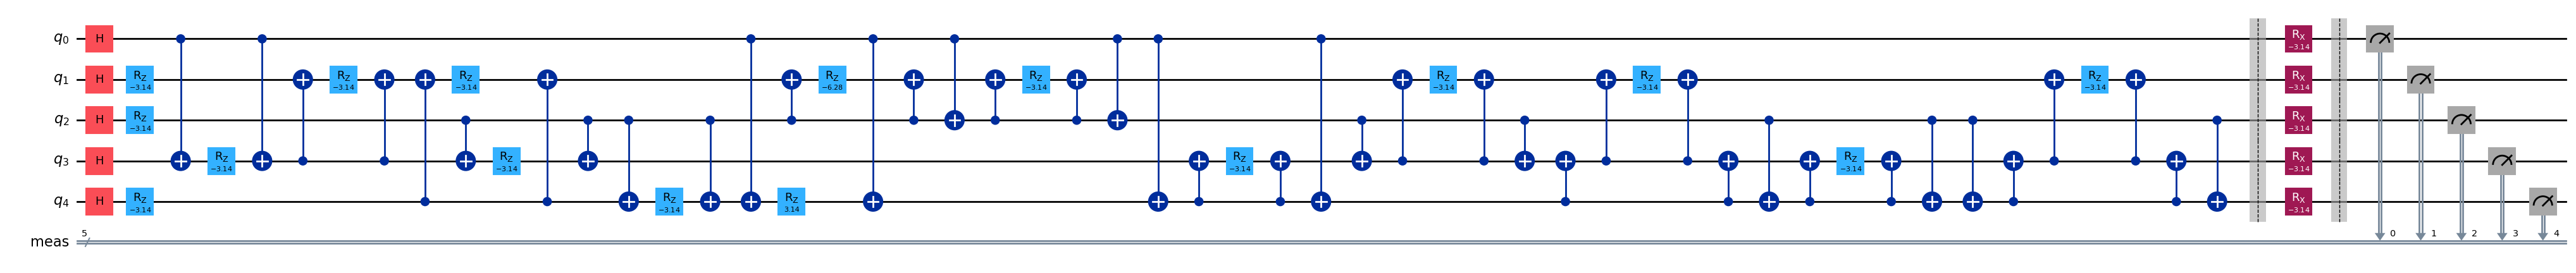

In [9]:
## draw quantum circuit
#print(qc_res)
qc_res.draw(fold=-1,output='mpl')
#qc_res.draw()